# Spine Segmentation

In [2]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from random import randint
from PIL import Image
import os
import pydicom

import tensorflow as tf
from tensorflow import keras
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint

In [3]:
# Init global variables
DATA_DIR = os.path.abspath('../Data/spine-segmentation')
X_FILES = [os.path.abspath(os.path.join(DATA_DIR, f'dicom/{i}')) for i in os.listdir(os.path.join(DATA_DIR, 'dicom'))]
Y_FILES = [os.path.abspath(os.path.join(DATA_DIR, f'filled/{i}')) for i in os.listdir(os.path.join(DATA_DIR, 'filled'))]

RESULTS = os.path.abspath('../Results')

IMG_SHAPE = (576, 240)
VALIDATION_NUM = 6
BATCH_SIZE = 1

## DataSet

In [4]:
class Data_train_generator(Sequence):
    def __init__(self, x_files_list: list, y_files_list: list, batch_size: int, new_image_size = None, shuffle = True) -> None:
        self.data = x_files_list
        self.labels = y_files_list
        self.batch_size = batch_size

        self.shuffle = shuffle
        self.new_image_size = new_image_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __open_png_y(self, file_path):
        img = Image.open(file_path)
        data = np.array(img, dtype="float32")
        
        if self.new_image_size != None:
            data = cv2.resize(data[:4608, :1920], dsize=self.new_image_size[::-1], interpolation=cv2.INTER_AREA)

        img.close()
        return np.reshape(data, (*self.new_image_size, 1))

    def __open_dcm_x(self, file_path):
        dcm = pydicom.dcmread(file_path)

        data = dcm.pixel_array.astype("float32") / 255

        if self.new_image_size != None:
            data = cv2.resize(data[:4608, :1920], dsize=self.new_image_size[::-1], interpolation=cv2.INTER_AREA)

        return np.reshape(data, (*self.new_image_size, 1))

    def __getitem__(self, index):
        batch_x = np.array(list(map(self.__open_dcm_x, self.data[index * self.batch_size: (index + 1) * self.batch_size])))
        batch_y = np.array(list(map(self.__open_png_y, self.labels[index * self.batch_size: (index + 1) * self.batch_size])))

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            for i in range(len(self.data)):
                ind_from, ind_to = randint(0, len(self.data) - 1), randint(0, len(self.data) - 1)
                self.data[ind_from], self.data[ind_to] = self.data[ind_to], self.data[ind_from]
                self.labels[ind_from], self.labels[ind_to] = self.labels[ind_to], self.labels[ind_from]

## Training And Validating

In [5]:
# training
def make_dice_loss(smooth=1e-6, gama=2):
    def dice_loss(y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, dtype=tf.float32)
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
        denominator = tf.reduce_sum(y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
        return 1 - tf.divide(nominator, denominator)
    return dice_loss

def make_focal_loss(alpha=0.25, gama=2):
    bin_ce = tf.losses.BinaryCrossentropy(from_logits=True)
    def focal_loss(y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, dtype=tf.float32)
        bin_cross_entropy = bin_ce(y_true, y_pred)
        m_pt = tf.pow((1 - tf.exp(-1 * bin_cross_entropy)), tf.constant(gama, dtype=tf.float32))
        return alpha * m_pt * bin_cross_entropy
    return focal_loss

def make_ms_ssim_loss(beta=1, gama=1, c1=1e-6, c2=9e-6, N=8):
    from keras.layers import UpSampling2D
    up2N_layer = UpSampling2D(size=(N, N), interpolation="nearest", data_format="channels_last")

    def ms_ssim_loss(y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, dtype=tf.float32)

        

        assert (input_shape[1] % N == 0 and input_shape[2] % N == 0)

        
    return ms_ssim_loss

focal_loss = make_focal_loss()
dice_loss = make_dice_loss()
ms_ssim_loss = make_ms_ssim_loss()

combine_loss = lambda y_true, y_pred: dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred) + ms_ssim_loss(y_true, y_pred)

data_gen = Data_train_generator(X_FILES[:-VALIDATION_NUM], Y_FILES[:-VALIDATION_NUM], BATCH_SIZE, IMG_SHAPE)
val_gen = Data_train_generator(X_FILES[-VALIDATION_NUM:], Y_FILES[-VALIDATION_NUM:], BATCH_SIZE, IMG_SHAPE)

model_checkpoint = ModelCheckpoint(
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    filepath=os.path.join(RESULTS, 'saved_weights/{epoch}-weights_unetpp.hdf5')
)

from model import make_unet3p

model_unet = make_unet3p((*IMG_SHAPE, 1), filters=[8, 16, 32, 64, 128], deep_supervision=True)

model_unet.compile(optimizer='Adam', loss={
    'output_1': combine_loss,
    'output_2': combine_loss,
    'output_3': combine_loss,
    'output_4': combine_loss
}, loss_weights=[1.0, 1.0, 1.0, 1.0])

#history_unet = model_unet.fit(x=data_gen, epochs=100, validation_data=val_gen, callbacks=[model_checkpoint])

## Testing

1/1 [==============================] - 2s 2s/step


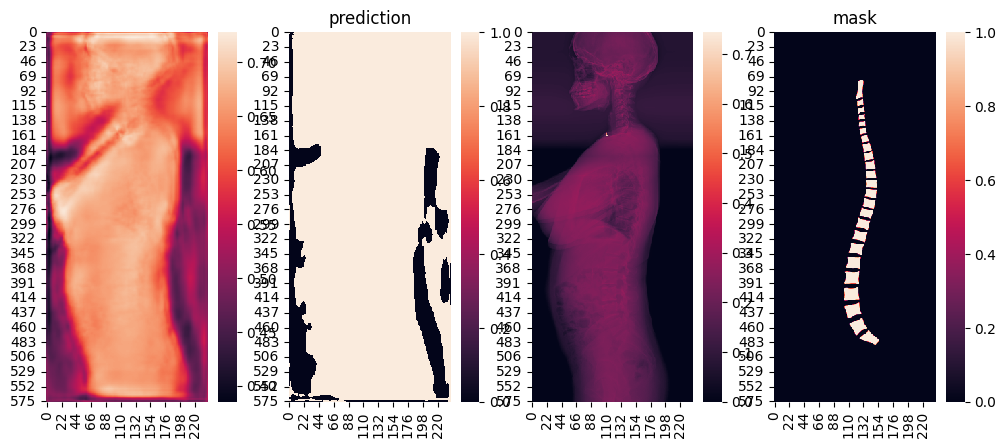

In [6]:
# testing
WEIGHTS2LOAD = os.path.join(RESULTS, 'saved_weights/1-weights_unetpp.hdf5')

TEST_IMG_PATH = os.path.join(DATA_DIR, 'dicom/050_SD.dcm')
TEST_TRUE_IMG_PATH = os.path.join(DATA_DIR, 'filled/050_SD.png')

test_gen = Data_train_generator([TEST_IMG_PATH], [TEST_TRUE_IMG_PATH], batch_size=1, new_image_size=IMG_SHAPE)

res = model_unet.predict(test_gen.__getitem__(0)[0], batch_size=1)
res = (res[0] + res[1] + res[2] + res[3]) / 4
res = res.reshape(IMG_SHAPE)

# Drawing Result

fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(12)
ax[3].set_title('mask')
ax[1].set_title('prediction')

sns.heatmap(res, ax=ax[0])
sns.heatmap(np.where(res > 0.5, 1, 0), ax=ax[1])
sns.heatmap(test_gen.__getitem__(0)[0].reshape(IMG_SHAPE), ax=ax[2])
sns.heatmap(test_gen.__getitem__(0)[1].reshape(IMG_SHAPE), ax=ax[3])
plt.show()

<AxesSubplot:>

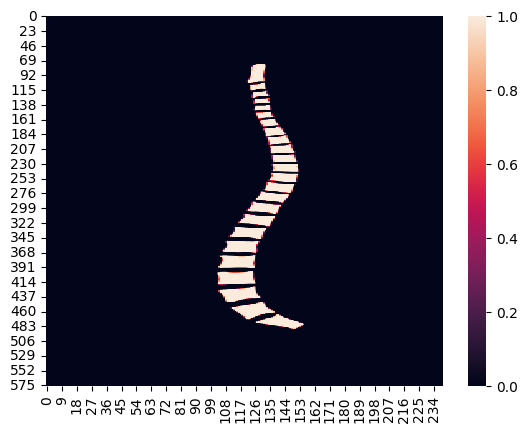

In [8]:
# point vertebras
IMG_PATH = os.path.join(DATA_DIR, 'filled/050_SD.png')

img = Image.open(IMG_PATH)
data = np.array(img, dtype="float32")

data = cv2.resize(data[:4608, :1920], dsize=IMG_SHAPE[::-1], interpolation=cv2.INTER_AREA)

img.close()

sns.heatmap(data)

